In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

2023-08-29 09:58:17.667611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-29 09:58:17.897850: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-29 09:58:17.899827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 09:58:20.052092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
max_epochs = 50
learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
original_dim = 784

In [3]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

2023-08-29 09:58:37.108383: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
class Encoder(K.layers.Layer):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = K.layers.Dense(units=hidden_dim, activation=tf.nn.relu)
           
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

In [5]:
class Decoder(K.layers.Layer):
    def __init__(self, hidden_dim, original_dim):
        super(Decoder, self).__init__()
        self.output_layer = K.layers.Dense(units=original_dim, activation=tf.nn.relu)
  
    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation 

In [6]:
class Autoencoder(K.Model):
    def __init__(self, hidden_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(hidden_dim=hidden_dim, original_dim=original_dim)

    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [7]:
autoencoder = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)
  
    return reconstruction_error

In [8]:
def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [9]:
autoencoder = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(autoencoder, opt, loss, training_dataset, epochs=max_epochs)

Epoch 1/50. Loss: 4.809042453765869
Epoch 2/50. Loss: 2.951697826385498
Epoch 3/50. Loss: 2.852235794067383
Epoch 4/50. Loss: 2.7769935131073
Epoch 5/50. Loss: 2.756716728210449
Epoch 6/50. Loss: 2.758220672607422
Epoch 7/50. Loss: 2.7476842403411865
Epoch 8/50. Loss: 2.7689590454101562
Epoch 9/50. Loss: 2.7306830883026123
Epoch 10/50. Loss: 2.722590684890747
Epoch 11/50. Loss: 2.733907699584961
Epoch 12/50. Loss: 2.730135679244995
Epoch 13/50. Loss: 2.719007968902588
Epoch 14/50. Loss: 2.7253856658935547
Epoch 15/50. Loss: 2.709822416305542
Epoch 16/50. Loss: 2.7215774059295654
Epoch 17/50. Loss: 2.73600697517395
Epoch 18/50. Loss: 2.68813157081604
Epoch 19/50. Loss: 2.721889019012451
Epoch 20/50. Loss: 2.7094218730926514
Epoch 21/50. Loss: 2.729078531265259
Epoch 22/50. Loss: 2.688049077987671
Epoch 23/50. Loss: 2.6739232540130615
Epoch 24/50. Loss: 2.719533681869507
Epoch 25/50. Loss: 2.7181942462921143
Epoch 26/50. Loss: 2.7300302982330322
Epoch 27/50. Loss: 2.7057456970214844
Epoc

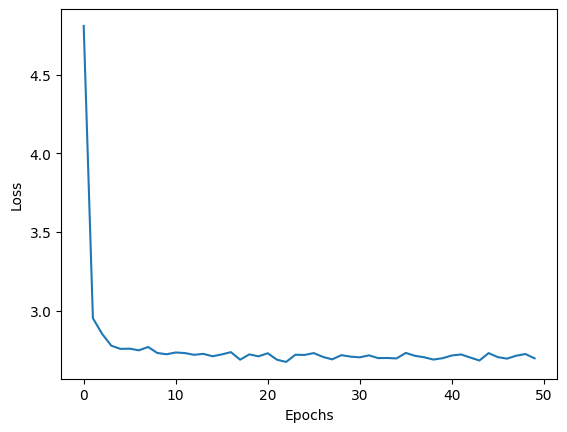

In [10]:
plt.plot(range(max_epochs), autoencoder.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

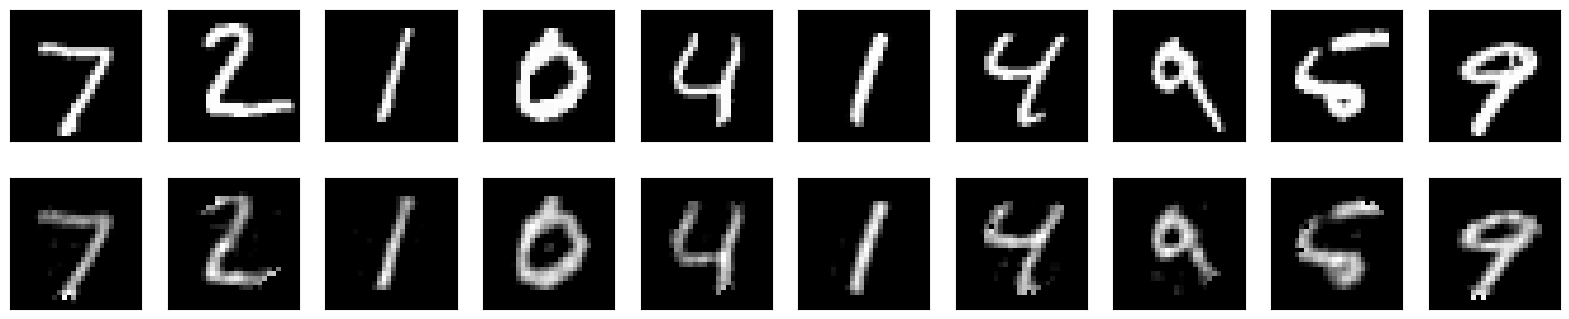

In [11]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

---